# Large-Scale Quantitative Evaluation of Dialogue Agents' Response Strategies against Offensive Users

This is an accompanying data analysis notebook for the "Large-Scale Quantitative Evaluation of Dialogue Agents' Response Strategies against Offensive Users" paper. 

In the first part of this notebook, we analyize the effectiveness of different strategies our bot uses when responding to offensive user remarks in stopping repeated abuse. In the second part of this notebook, we provide additional analysis on the types of offensive utterances. However, due to limitations of our classification of offensive utterances, we will not include the second part of our analysis in our paper.


## Setup and Data Loading

Since we are not allowed to share real user conversations, we processed the user conversations and created an anonymized aggregated dataset from the data we collected over 2 months (May 23, 2020 to August 14, 2020). Details about our data collection methodology can be found in our paper.

In [1]:
# Import statements
from collections import defaultdict, Counter
from itertools import combinations

import os
import csv
import json
import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
from IPython.display import HTML, display
from scipy.stats import fisher_exact, chi2_contingency, ttest_ind

In [2]:
from statsmodels.stats.contingency_tables import Table2x2

In [3]:
import statsmodels
statsmodels.__version__

'0.12.2'

In [4]:
with open('data/anonymized_conversations.jsonl', 'r') as file_handle:
    data = [json.loads(line) for line in file_handle]

In [5]:
data[0]

{'rating': 4.0,
 '_response_strategy': 'E3C6 - RegularResponse (prompt)',
 'response_strategy': 'AVOIDANCE+REDIRECT',
 'offensive_turns': [{'turn_index': 13,
   'offense_type': 'sexual',
   'responded': False},
  {'turn_index': 14, 'offense_type': 'sexual', 'responded': True}],
 'num_total_turns': 17,
 'id': 0}

The dataset contains meta data of each conversations. Specifically, it contains the following fields

- `id`: an unique identification of this conversation (in reality this is just an index)
- `rating`: the rating that we received for each conversation
- `num_total_turns`: the number of total turns in this conversation
- `response_strategy`: the response strategy corresponding to the strategies in the paper.
- `offensive_turns`: a list of turns that we identified as offensive. Each offensive turn contains the following fields
    - `turn_index`: the index of the turn
    - `offense_type`: the type of offense as identified by the authors
    - `responded`: whether we responded to the offense or not
    
As we can see from the first example of the data, we might have not responded to every offense due to the limitation described in our paper. We will still count them as offensive during our analysis to make our results accurate

## Part 0: Summary Statistics

In this part, we print out summary statistics of our data such as the sample size for each response strategy

In [6]:
print(f'There are {len(data)} conversations in our dataset')
print(f"There are {sum(convo['num_total_turns'] // 2 for convo in data)} user utterances total," +\
      f" out of which {sum(len(convo['offensive_turns']) for convo in data)} user utterances are offensive")

There are 13276 conversations in our dataset
There are 235775 user utterances total, out of which 49511 user utterances are offensive


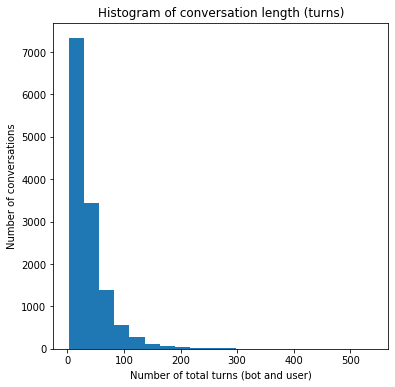

In [7]:
plt.figure(figsize=(6, 6))
plt.hist([convo['num_total_turns'] for convo in data], bins=20)
plt.title('Histogram of conversation length (turns)')
plt.xlabel('Number of total turns (bot and user)')
plt.ylabel('Number of conversations')
plt.show()

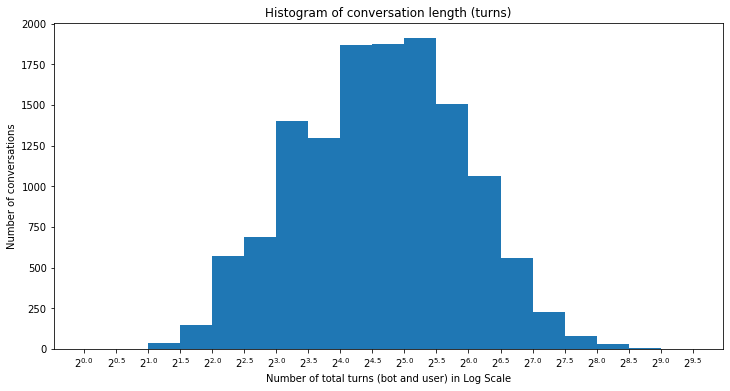

In [8]:
logbins = 2 ** np.arange(10, step=0.5)
plt.figure(figsize=(12, 6))
plt.hist([convo['num_total_turns'] for convo in data], bins=logbins)
plt.xscale('log', basex=2)
plt.title('Histogram of conversation length (turns)')
plt.xlabel('Number of total turns (bot and user) in Log Scale')
plt.ylabel('Number of conversations')
plt.xticks(logbins, [f'$2^{{{i}}}$' for i in np.arange(10, step=0.5)])
plt.savefig('plot/convo_length_histogram.png')

As we can see from the plots above, the distribution of conversation lengths is heavily right skewed. Plotting the histogram on log scale shows that it is normally distributed on the log scale.

In [9]:
strategies = sorted(list(set([convo['response_strategy'] for convo in data]) - {'AVOIDANCE+PROMPT (CONTEXTUAL)'}))

In [10]:
sample_sizes = defaultdict(lambda: 0)
for strategy in strategies:
    for convo in data:
        if convo['response_strategy'] == strategy:
            sample_sizes[strategy] += 1

headers = ['Response Strategy', 'Sample Size']
rows = list(map(list, sample_sizes.items()))
display(HTML(tabulate(rows, headers=headers, tablefmt='html')))
rows = [["\\texttt{" + row[0] + "}"] + row[1:] for row in rows]
print(tabulate(rows, headers=headers, tablefmt='latex_raw'))

Response Strategy,Sample Size
AVOIDANCE,1724
AVOIDANCE+NAME,867
AVOIDANCE+NAME+REDIRECT,860
AVOIDANCE+REDIRECT,1759
AVOIDANCE+REDIRECT (CONTEXTUAL),1802
COUNTER+REDIRECT (CONTEXTUAL),1859
EMPATHETIC+REDIRECT (CONTEXTUAL),1814
WHY,1755
WHY+NAME,836


\begin{tabular}{lr}
\hline
 Response Strategy                         &   Sample Size \\
\hline
 \texttt{AVOIDANCE}                        &          1724 \\
 \texttt{AVOIDANCE+NAME}                   &           867 \\
 \texttt{AVOIDANCE+NAME+REDIRECT}          &           860 \\
 \texttt{AVOIDANCE+REDIRECT}               &          1759 \\
 \texttt{AVOIDANCE+REDIRECT (CONTEXTUAL)}  &          1802 \\
 \texttt{COUNTER+REDIRECT (CONTEXTUAL)}    &          1859 \\
 \texttt{EMPATHETIC+REDIRECT (CONTEXTUAL)} &          1814 \\
 \texttt{WHY}                              &          1755 \\
 \texttt{WHY+NAME}                         &           836 \\
\hline
\end{tabular}


Note that there is a noticeable difference in the sample sizes since we only select strategies with NAME factor if we actually received a user's name in the beginning of the conversation. A limitation of this approach is that there could potentially be correlations of offensive behavior with whether or not the user provided a name in the beginning of the conversation. Unfortunately we did not think about this case when we designed the experiments and were unable to recover that information and this will remain a limitation of our research.

## Part 1. Response Strategy Analysis

We perform our response strategy analysis in the first part of this notebook. According to our hypothesis in the paper, we test strategies crossing the following factors

1. PROMPT: Whether giving a prompt to the user and actively redirecting the conversation has a positive effect in stopping and curbing abuse
2. NAME: Whether using user's names (provided to us voluntarily) is able to assist in stopping abuse
3. WHY Strategies: Whether we should ask the user "why" they abuse us

The following helper functions is used by all the analysis below:

In [11]:
def derive_data(data):
    strategy_grouped = {}
    for metadata in data:
        strat = metadata['response_strategy']
        if strat not in strategy_grouped:
            strategy_grouped[strat] = {'reoffend': [],
                                       'turns_til_next': [], 
                                       'turns_til_end': []}
        first_responded_i = next(i for i, turn in enumerate(metadata['offensive_turns']) if turn['responded'])
        reoffend = len(metadata['offensive_turns'][first_responded_i+1:]) > 0
        strategy_grouped[strat]['reoffend'].append(reoffend)
        if reoffend:
            strategy_grouped[strat]['turns_til_next'].append(
                metadata['offensive_turns'][first_responded_i + 1]['turn_index'] - \
                metadata['offensive_turns'][first_responded_i]['turn_index'])
        else:
            strategy_grouped[strat]['turns_til_end'].append(
                metadata['num_total_turns'] - metadata['offensive_turns'][first_responded_i]['turn_index'] - 1)
    return strategy_grouped

derived_data = derive_data(data)

The derived data is a dictionary of the following format

- key: strategy
- value, a dictionary of:
    - reoffend: a list containing a boolean value indicating reoffenses
    - turns_til_next: a list containing the number of turns until the next reoffense assuming the user did reoffend
    - turns_til_end: a list containing the number of turns until the end of the conversation assuming the user did NOT reoffend

### Summary of all metrics

Here we summarize all of our metrics, namely
1. Reoffense (The reoffense ratio)
2. Next (The average number of turns until the next offense (assume there is one))
3. End (The average number of turns until the end of the conversation (assuming there is no reoffense))

In [12]:
def gen_table(strats, derived_data):
    headers = ['Strategy', 'Re-offense', 'CI', 'Next', 'CI', 'End', 'CI']
    rows = []
    for s in strats:
        rows.append([
            s,
            '{:.3g}'.format(np.mean(derived_data[s]['reoffend'])),
            '$\pm${:.3g}'.format(np.std(derived_data[s]['reoffend']) / np.sqrt(len(derived_data[s]['reoffend']))),
            '{:.3g}'.format(np.mean(derived_data[s]['turns_til_next'])),
            '$\pm${:.3g}'.format(np.std(derived_data[s]['turns_til_next']) / np.sqrt(len(derived_data[s]['turns_til_next']))),
            '{:.3g}'.format(np.mean(derived_data[s]['turns_til_end'])),
            '$\pm${:.3g}'.format(np.std(derived_data[s]['turns_til_end']) / np.sqrt(len(derived_data[s]['turns_til_end'])))
        ])
    display(HTML(tabulate(rows, headers=headers, tablefmt='html')))
    latex_code = tabulate(rows, headers=headers, tablefmt='latex_raw')
    return latex_code

latex_code = gen_table(strategies, derived_data)
print(latex_code)

Strategy,Re-offense,CI,Next,CI,End,CI
AVOIDANCE,0.918,$\pm$0.0066,1.01,$\pm$0.00557,1.08,$\pm$0.204
AVOIDANCE+NAME,0.938,$\pm$0.00821,1.02,$\pm$0.0172,1.11,$\pm$0.255
AVOIDANCE+NAME+REDIRECT,0.406,$\pm$0.0167,8.6,$\pm$0.809,16.3,$\pm$0.983
AVOIDANCE+REDIRECT,0.466,$\pm$0.0119,7.32,$\pm$0.434,13.5,$\pm$0.582
AVOIDANCE+REDIRECT (CONTEXTUAL),0.465,$\pm$0.0117,6.89,$\pm$0.373,12.8,$\pm$0.529
COUNTER+REDIRECT (CONTEXTUAL),0.471,$\pm$0.0116,6.83,$\pm$0.412,12.3,$\pm$0.617
EMPATHETIC+REDIRECT (CONTEXTUAL),0.432,$\pm$0.0116,6.72,$\pm$0.366,13.1,$\pm$0.557
WHY,0.952,$\pm$0.00512,1.05,$\pm$0.0312,1.09,$\pm$0.326
WHY+NAME,0.947,$\pm$0.00772,1.33,$\pm$0.321,2.41,$\pm$1.53


\begin{tabular}{lrlrlrl}
\hline
 Strategy                         &   Re-offense & CI           &   Next & CI           &   End & CI         \\
\hline
 AVOIDANCE                        &        0.918 & $\pm$0.0066  &   1.01 & $\pm$0.00557 &  1.08 & $\pm$0.204 \\
 AVOIDANCE+NAME                   &        0.938 & $\pm$0.00821 &   1.02 & $\pm$0.0172  &  1.11 & $\pm$0.255 \\
 AVOIDANCE+NAME+REDIRECT          &        0.406 & $\pm$0.0167  &   8.6  & $\pm$0.809   & 16.3  & $\pm$0.983 \\
 AVOIDANCE+REDIRECT               &        0.466 & $\pm$0.0119  &   7.32 & $\pm$0.434   & 13.5  & $\pm$0.582 \\
 AVOIDANCE+REDIRECT (CONTEXTUAL)  &        0.465 & $\pm$0.0117  &   6.89 & $\pm$0.373   & 12.8  & $\pm$0.529 \\
 COUNTER+REDIRECT (CONTEXTUAL)    &        0.471 & $\pm$0.0116  &   6.83 & $\pm$0.412   & 12.3  & $\pm$0.617 \\
 EMPATHETIC+REDIRECT (CONTEXTUAL) &        0.432 & $\pm$0.0116  &   6.72 & $\pm$0.366   & 13.1  & $\pm$0.557 \\
 WHY                              &        0.952 & $\pm$0.00512 &

### Part 1.1 Reoffense Ratio (a.k.a. Reoffense)

We first summarizes the reoffense ratio of every strategy. Then, we analyze the pair-wise comparisons of reoffense ratios and test the hypothesis that different pairs of strategies are have the same ratio

In [13]:
def get_paired_statistic(derived_data, stat, *strats):
    assert len(strats) > 1, 'must have more than 2 strats for comparison'
    strats_data = [derived_data[strat][stat] for strat in strats]
    statistic = {}
    for i, strat_data in enumerate(strats_data):
        statistic[f'mean{i}'] = np.mean(strat_data)
        statistic[f'se{i}'] = np.std(strat_data) / np.sqrt(len(strat_data))
        if i > 0:
            statistic[f'mean_diff_0_{i}'] = np.mean(strat_data) - np.mean(strats_data[0])
            statistic[f'p_value_0_{i}'] = ttest_ind(strats_data[0], strat_data).pvalue
            if all(elem in [0, 1] for elem in strat_data):
                a, b = np.sum(strats_data[0]), len(strats_data[0])
                c, d = np.sum(strat_data), len(strat_data)
                tab = Table2x2([[c, d], [a, b]])
                statistic['or'] = tab.oddsratio
                statistic['or_confint'] = tab.oddsratio_confint()
                statistic['or_p'] = tab.oddsratio_pvalue(1)
            else:
                s = np.sqrt(((len(strats_data[0]) - 1) * np.var(strats_data[0]) 
                              + (len(strat_data) - 1) * np.var(strat_data)) / 
                            (len(strats_data[0]) + len(strat_data) - 2))
                d = (np.mean(strat_data) - np.mean(strats_data[0])) / s
                statistic['cohens_d'] = d
            
    return statistic

get_paired_statistic(derived_data, 'reoffend', 'AVOIDANCE+REDIRECT', 'EMPATHETIC+REDIRECT (CONTEXTUAL)')
# get_paired_statistic(derived_data, 'turns_til_next', 'AVOIDANCE', 'AVOIDANCE+REDIRECT')

{'mean0': 0.4661739624786811,
 'se0': 0.011894356829214197,
 'mean1': 0.4316427783902977,
 'se1': 0.011629319158359668,
 'mean_diff_0_1': -0.034531184088383404,
 'p_value_0_1': 0.03801290618600518,
 'or': 0.9259263990104069,
 'or_confint': (0.8229775802044167, 1.0417534049608348),
 'or_p': 0.20062972280131564}

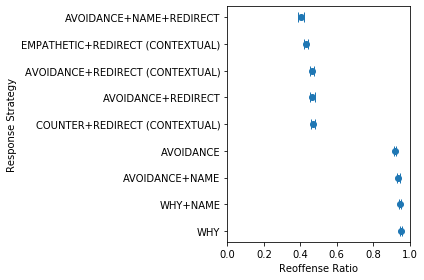

In [14]:
statistics = get_paired_statistic(derived_data, 'reoffend', *strategies)
y = np.array([statistics[f'mean{i}'] for i, _ in enumerate(strategies)])
err = np.array([statistics[f'se{i}'] for i, _ in enumerate(strategies)])
yticks = np.array(strategies)
sort_order = np.flip(np.argsort(y))
y, err, yticks = y[sort_order], err[sort_order], yticks[sort_order]

title = 'Re-offense Ratio'
plt.figure(figsize=(6, 4))
plt.errorbar(y, np.arange(len(y)), xerr=err, fmt='o', capsize=5)
plt.xticks(np.arange(0, 1.1, 0.2))
plt.yticks(np.arange(len(y)), yticks)
# plt.title(title)
plt.xlabel('Reoffense Ratio')
plt.ylabel('Response Strategy')
plt.tight_layout()
plt.savefig(os.path.join('plot', title.replace(' ', '_').lower() + '.png'))

As we can see from the plot above, the why strategies performs the worst out of all the strategies. Then, we can see that prompt strategies perform much better than strategies without a prompt. We also see that a generic avoidance strategy that uses user's names and a prompt perform the best out of all the strategies tried.

### Part 1.1.1 Significance Analysis on the Re-offense Ratio (a.k.a. Reoffense)

Here we run several one way F-test to test the null hypothesis that the reoffense ratio is the same between 2 experiments.

In [15]:
def gen_table(derived_data, groups_of_strats, show_insig=True):
    headers = ['', 'Base', 'Reoffense', 'Alternative', 'Reoffense', 'Delta', 'p', 'or', 'or_conf']
    rows = []
    for strats in groups_of_strats:
        statistics = get_paired_statistic(derived_data, 'reoffend', *strats)
        for i in range(1, len(strats)):
            if statistics[f'p_value_0_{i}'] < 0.05 or show_insig:
#                 print(statistics['or_p'])
                rows.append([
                    len(rows) + 1,
                    strats[0].replace(' (CONTEXTUAL)', '*'), "{:.3f}".format(statistics[f'mean0']),
                    strats[i].replace(' (CONTEXTUAL)', '*'), "{:.3f}".format(statistics[f'mean{i}']),
                    "\\textbf{{{:.3f}}}".format(statistics[f'mean_diff_0_{i}']) \
                        if statistics[f'p_value_0_{i}'] < 0.05 / 4 \
                        else "{:.3f}".format(statistics[f'mean_diff_0_{i}']), 
                    "{:.3g}".format(statistics[f'p_value_0_{i}']) \
                        if statistics[f'p_value_0_{i}'] > 1e-10 else "$<$ 1e-10",
                    "\\textbf{{{:.3f}}}".format(statistics['or']) \
                        if statistics[f'or_p'] < 0.05 \
                        else "{:.3f}".format(statistics['or']), 
                    ["{:.3g}".format(confint) for confint in statistics['or_confint']],
                ])
    display(HTML(tabulate(rows, headers=headers, tablefmt='html')))
    rows = [[row[0]] + ["\\texttt{" + row[1] + "}"] + [row[2]] + ["\\texttt{" + row[3] + "}"] + row[4:]
            for row in rows]
    latex_code = tabulate(rows, headers=headers, tablefmt='latex_raw')
    return latex_code

#### a. PROMPT Strategies

We test strategies with (prompt) in them vs (no prompt) in them

In [16]:
latex_code = gen_table(derived_data, 
        [('AVOIDANCE', 'AVOIDANCE+REDIRECT'), ('AVOIDANCE+NAME', 'AVOIDANCE+NAME+REDIRECT')])
# print(latex_code)

,Base,Reoffense,Alternative,Reoffense,Delta,p,or,or_conf
1,AVOIDANCE,0.918,AVOIDANCE+REDIRECT,0.466,\textbf{-0.452},$<$ 1e-10,\textbf{0.508},"['0.456', '0.565']"
2,AVOIDANCE+NAME,0.938,AVOIDANCE+NAME+REDIRECT,0.406,\textbf{-0.532},$<$ 1e-10,\textbf{0.433},"['0.37', '0.506']"


The above tests show that, controling response types and user names, using prompt has statistically significant improvements over not using prompts. This means that when given a prompt, user are much more likely to end the abuse, either by stopping the conversation right away or by re-engaging the bot with a different topic. However, when looking at the previous analysis on turns until the next reoffense, we see that it also significantly delays reoffenses, which means that even when user do offend again, they actually re-engage with the conversation before eventually giving up. 

This validates previous papers where users will often be frustrated when we are unable to perform a task (in this case, talk about something that user wants to talk about, namely sexual topics), but at the same time give us a chance to recover from such failure. With no-prompt strategies, we made no attempt to recover from such a failure, and thus user become more angry and frustrated. However, with prompt strategies, we made a deliberate attempt to recover from such failure and we see that user recognized our attempt and either accepted the new topic for the rest of the conversation, or until our conversation falls apart again. This suggests that social bots should always make an attempt to not only passively avoid such topics, but actively redirect the conversation into a topic that also interests the user.

#### b. NAME Strategies

In [17]:
latex_code = gen_table(derived_data, [('AVOIDANCE+REDIRECT', 'AVOIDANCE+NAME+REDIRECT'), 
                           ('AVOIDANCE', 'AVOIDANCE+NAME'), 
                           ('WHY', 'WHY+NAME')])
# print(latex_code)

,Base,Reoffense,Alternative,Reoffense,Delta,p,or,or_conf
1,AVOIDANCE+REDIRECT,0.466,AVOIDANCE+NAME+REDIRECT,0.406,\textbf{-0.060},0.00351,0.871,"['0.75', '1.01']"
2,AVOIDANCE,0.918,AVOIDANCE+NAME,0.938,0.020,0.0758,1.021,"['0.908', '1.15']"
3,WHY,0.952,WHY+NAME,0.947,-0.004,0.646,0.996,"['0.885', '1.12']"


We can see from the table above that using user's name is only effective when used together with a prompt. This is in line with the previous section where we found that the interaction term between prompt and name is small but significant. This means that using users' names does not stop the offenses directly, but rather compel the user to follow the new direction that we propose. This suggests that when the user's name is available, it is better to use it together with a prompt. 

#### c. WHY Strategy

In [18]:
latex_code = gen_table(derived_data, [('AVOIDANCE+NAME', 'WHY+NAME'), ('AVOIDANCE', 'WHY')])
# print(latex_code)

,Base,Reoffense,Alternative,Reoffense,Delta,p,or,or_conf
1,AVOIDANCE+NAME,0.938,WHY+NAME,0.947,0.010,0.393,1.01,"['0.881', '1.16']"
2,AVOIDANCE,0.918,WHY,0.952,\textbf{0.033},6.49e-05,1.036,"['0.942', '1.14']"


As we can see from the table above, using hte why strategy actually had a significant 3\% increase in reoffend rate, while there is no significant difference when used together with user's names. This suggests that our original hypothesis that asking user why they said what they said would give them time to reflect on their behavior is false. Rather, we actually invited more abuse by asking the user to justify their abuse. This further validates the hypothesis that it is much better to move on quickly to a new topic. This suggests that social bots should always switch topic as fast as possible.

#### d. CONTEXTUAL Strategies

In [19]:
latex_code = gen_table(derived_data, [('AVOIDANCE+REDIRECT', 'COUNTER+REDIRECT (CONTEXTUAL)'), 
                           ('AVOIDANCE+REDIRECT', 'EMPATHETIC+REDIRECT (CONTEXTUAL)')])
# print(latex_code)

,Base,Reoffense,Alternative,Reoffense,Delta,p,or,or_conf
1,AVOIDANCE+REDIRECT,0.466,COUNTER+REDIRECT*,0.471,0.005,0.786,1.01,"['0.9', '1.13']"
2,AVOIDANCE+REDIRECT,0.466,EMPATHETIC+REDIRECT*,0.432,-0.035,0.038,0.926,"['0.823', '1.04']"


As we can see form the table above, there is a significant 6\% reduction in reoffend rate when using the empathetic strategy together with a prompt. This is in line with previous research CITE HERE that empathetic responses performs better than other types of responses. 

#### e. Master table

Here we generate the final table that is used in our paper. It is a single table containing all the sub tables above

In [20]:
latex_code = gen_table(derived_data, [('AVOIDANCE', 'AVOIDANCE+REDIRECT'), 
                           ('AVOIDANCE+NAME', 'AVOIDANCE+NAME+REDIRECT'),
                           ('AVOIDANCE+REDIRECT', 'AVOIDANCE+NAME+REDIRECT'), 
                           ('AVOIDANCE', 'AVOIDANCE+NAME'), 
                           ('WHY', 'WHY+NAME'),
                           ('AVOIDANCE+NAME', 'WHY+NAME'), 
                           ('AVOIDANCE', 'WHY'),
                           ('AVOIDANCE+REDIRECT', 'COUNTER+REDIRECT (CONTEXTUAL)'), 
                           ('AVOIDANCE+REDIRECT', 'EMPATHETIC+REDIRECT (CONTEXTUAL)')
                          ])
print(latex_code)

,Base,Reoffense,Alternative,Reoffense,Delta,p,or,or_conf
1,AVOIDANCE,0.918,AVOIDANCE+REDIRECT,0.466,\textbf{-0.452},$<$ 1e-10,\textbf{0.508},"['0.456', '0.565']"
2,AVOIDANCE+NAME,0.938,AVOIDANCE+NAME+REDIRECT,0.406,\textbf{-0.532},$<$ 1e-10,\textbf{0.433},"['0.37', '0.506']"
3,AVOIDANCE+REDIRECT,0.466,AVOIDANCE+NAME+REDIRECT,0.406,\textbf{-0.060},0.00351,0.871,"['0.75', '1.01']"
4,AVOIDANCE,0.918,AVOIDANCE+NAME,0.938,0.020,0.0758,1.021,"['0.908', '1.15']"
5,WHY,0.952,WHY+NAME,0.947,-0.004,0.646,0.996,"['0.885', '1.12']"
6,AVOIDANCE+NAME,0.938,WHY+NAME,0.947,0.010,0.393,1.010,"['0.881', '1.16']"
7,AVOIDANCE,0.918,WHY,0.952,\textbf{0.033},6.49e-05,1.036,"['0.942', '1.14']"
8,AVOIDANCE+REDIRECT,0.466,COUNTER+REDIRECT*,0.471,0.005,0.786,1.010,"['0.9', '1.13']"
9,AVOIDANCE+REDIRECT,0.466,EMPATHETIC+REDIRECT*,0.432,-0.035,0.038,0.926,"['0.823', '1.04']"


\begin{tabular}{rlrlrllll}
\hline
    & Base                        &   Reoffense & Alternative                      &   Reoffense & Delta           & p         & or             & or_conf            \\
\hline
  1 & \texttt{AVOIDANCE}          &       0.918 & \texttt{AVOIDANCE+REDIRECT}      &       0.466 & \textbf{-0.452} & $<$ 1e-10 & \textbf{0.508} & ['0.456', '0.565'] \\
  2 & \texttt{AVOIDANCE+NAME}     &       0.938 & \texttt{AVOIDANCE+NAME+REDIRECT} &       0.406 & \textbf{-0.532} & $<$ 1e-10 & \textbf{0.433} & ['0.37', '0.506']  \\
  3 & \texttt{AVOIDANCE+REDIRECT} &       0.466 & \texttt{AVOIDANCE+NAME+REDIRECT} &       0.406 & \textbf{-0.060} & 0.00351   & 0.871          & ['0.75', '1.01']   \\
  4 & \texttt{AVOIDANCE}          &       0.918 & \texttt{AVOIDANCE+NAME}          &       0.938 & 0.020           & 0.0758    & 1.021          & ['0.908', '1.15']  \\
  5 & \texttt{WHY}                &       0.952 & \texttt{WHY+NAME}                &       0.947 & -0.004          & 0.

#### Take-aways

All the analysis above validates several of our hypothesis while disapproving others. To summarize, here are the insights that we derived

1. Social bots should always suggest a new topic of discussion whenever possible. Staying in the same topic by asking why or simply not suggesting a new topic is not only seen as a failure of handling such responses but also does not give user "a way out" of the abuse. Actively redirecting the conversation is not only effective but also necessary comparing to passively stopping abuse.
2. Using user's names does not have significant impact on stopping abuse directly, but it compels the user to follow a new direction when given, suggesting that it contributes to stopping abuse when used together with a prompt
3. Base strategies matter. The contextual empathetic strategy performs better than other strategies.

### Part 1.2 Average Number of Turns Until the Next Re-offense (a.k.a. Next)

Assuming that the user did reoffend, does different strategy help in delaying that reoffense? We measure this by averaging the number of turns until the next re-offense. The longer we are able to delay the reoffense the more successful the strategy is in mitigating offensive behavior.

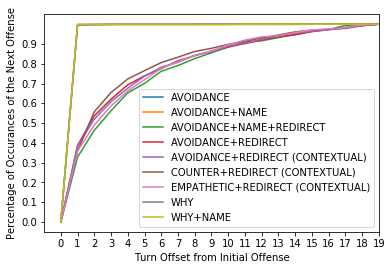

In [21]:
x_lim = 20
ys = []
for strategy in strategies:
    y = np.zeros(x_lim)
    c = Counter(derived_data[strategy]['turns_til_next'])
    for turn_idx, count in sorted(c.items(), key=lambda tup: tup[0]):
        if turn_idx < x_lim and turn_idx > 0:
            y[turn_idx] = count
    ys = ys + [y]
plt.figure(figsize=(6, 4))
for y in ys:
    plt.plot(np.cumsum(y) / np.sum(y), '-')
plt.xlim(-1, x_lim-1)
plt.xticks(np.arange(0, x_lim))
plt.yticks(np.arange(0, 1, 0.1))
plt.legend(strategies)
plt.xlabel('Turn Offset from Initial Offense')
plt.ylabel('Percentage of Occurances of the Next Offense')
plt.savefig('cumulative_plot_next_offense.png')

The above is a cumulative plot of percentage of occurances of the next offense against the offset of that offense from the initial offense. For example, we can see that 65\% of conversations in which we responded to the initial offense with the `COUNTER+REDIRECT (CONTEXTUAL)` strategy have offended within 2 turns. Turn index 0 is artificially set to 0 since no repeated offenses has occured at offset 0. 

As we can see, the flatter the curve the more effective the strategy, since it means that the strategy is able to delay the offense by more turns. We can easily see that, during almost all conversations, user will re-offend immediately after given the responses without a prompt. Though the effectiveness of other strategies are unclear, it seems tho `AVOIDANCE+NAME+REDIRECT` and `EMPATHETIC+REDIRECT (CONTEXTUAL)` strategies perform slightly better than other strategies in delaying the reoffense 

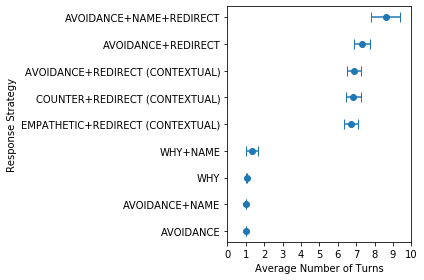

In [22]:
# All strategies plot

statistics = get_paired_statistic(derived_data, 'turns_til_next', *strategies)
y = np.array([statistics[f'mean{i}'] for i, _ in enumerate(strategies)])
err = np.array([statistics[f'se{i}'] for i, _ in enumerate(strategies)])
yticks = np.array(strategies)
sort_order = np.argsort(y)
y, err, yticks = y[sort_order], err[sort_order], yticks[sort_order]

title = 'Average Number of Turns Until the Next Reoffense'
plt.figure(figsize=(6, 4))
plt.errorbar(y, np.arange(len(y)), xerr=err, fmt='o', capsize=5)
plt.xticks(np.arange(0, 11, 1))
plt.yticks(np.arange(len(y)), yticks)
# plt.title(title)
plt.xlabel('Average Number of Turns')
plt.ylabel('Response Strategy')
plt.tight_layout()
plt.savefig(os.path.join('plot', title.replace(' ', '_').lower() + '.png'))

It seems that `AVOIDANCE+NAME+REDIRECT` strategy is not only more effective in stopping abuse, it also does better in delaying offense in case the user did reoffend. On average, said strategy is able to delay user reoffense by more than 8 turns.

### Part 1.2.1 Significance Analysis on the Average Number of Turns Until the Next Reoffense (Next)

We run similar analysis as part 1.1.1 on the average number of turns until the next reoffense metric.

In [23]:
def gen_table(derived_data, groups_of_strats, show_insig=False):
    headers = ['', 'Base', 'Next', 'Alternative', 'Next', 'Delta', 'p', 'cohens_d']
    rows = []
    for strats in groups_of_strats:
        statistics = get_paired_statistic(derived_data, 'turns_til_next', *strats)
        for i in range(1, len(strats)):
            if statistics[f'p_value_0_{i}'] < 0.05 or show_insig:
                rows.append([
                    len(rows) + 1,
                    strats[0].replace(' (CONTEXTUAL)', '*'), "{:.3f}".format(statistics[f'mean0']),
                    strats[i].replace(' (CONTEXTUAL)', '*'), "{:.3f}".format(statistics[f'mean{i}']),
                    "{:.3f}".format(statistics[f'mean_diff_0_{i}']), 
                    "{:.3g}".format(statistics[f'p_value_0_{i}']) \
                        if statistics[f'p_value_0_{i}'] > 1e-10 else "$<$ 1e-10",
                    "{:.3g}".format(statistics['cohens_d'])
                ])
    display(HTML(tabulate(rows, headers=headers, tablefmt='html')))
    rows = [[row[0]] + ["\\texttt{" + row[1] + "}"] + [row[2]] + ["\\texttt{" + row[3] + "}"] + row[4:]
            for row in rows]
    latex_code = tabulate(rows, headers=headers, tablefmt='latex_raw')
    return latex_code

In [24]:
latex_code = gen_table(derived_data, [('AVOIDANCE', 'AVOIDANCE+REDIRECT'), 
                           ('AVOIDANCE+NAME', 'AVOIDANCE+NAME+REDIRECT'),
                           ('AVOIDANCE+REDIRECT', 'AVOIDANCE+NAME+REDIRECT'), 
                           ('AVOIDANCE', 'AVOIDANCE+NAME'), 
                           ('WHY', 'WHY+NAME'),
                           ('AVOIDANCE+NAME', 'WHY+NAME'), 
                           ('AVOIDANCE', 'WHY'),
                           ('AVOIDANCE+REDIRECT', 'COUNTER+REDIRECT (CONTEXTUAL)'), 
                           ('AVOIDANCE+REDIRECT', 'EMPATHETIC+REDIRECT (CONTEXTUAL)')
                          ], True)
print(latex_code)

,Base,Next,Alternative,Next,Delta,p,cohens_d
1,AVOIDANCE,1.01,AVOIDANCE+REDIRECT,7.321,6.311,$<$ 1e-10,0.869
2,AVOIDANCE+NAME,1.017,AVOIDANCE+NAME+REDIRECT,8.602,7.584,$<$ 1e-10,0.915
3,AVOIDANCE+REDIRECT,7.321,AVOIDANCE+NAME+REDIRECT,8.602,1.281,0.132,0.0964
4,AVOIDANCE,1.01,AVOIDANCE+NAME,1.017,0.007,0.626,0.0211
5,WHY,1.046,WHY+NAME,1.333,0.288,0.202,0.0551
6,AVOIDANCE+NAME,1.017,WHY+NAME,1.333,0.316,0.319,0.0498
7,AVOIDANCE,1.01,WHY,1.046,0.035,0.276,0.0383
8,AVOIDANCE+REDIRECT,7.321,COUNTER+REDIRECT*,6.834,-0.486,0.416,-0.0395
9,AVOIDANCE+REDIRECT,7.321,EMPATHETIC+REDIRECT*,6.718,-0.603,0.291,-0.0529


\begin{tabular}{rlrlrrlr}
\hline
    & Base                        &   Next & Alternative                      &   Next &   Delta & p         &   cohens_d \\
\hline
  1 & \texttt{AVOIDANCE}          &  1.01  & \texttt{AVOIDANCE+REDIRECT}      &  7.321 &   6.311 & $<$ 1e-10 &     0.869  \\
  2 & \texttt{AVOIDANCE+NAME}     &  1.017 & \texttt{AVOIDANCE+NAME+REDIRECT} &  8.602 &   7.584 & $<$ 1e-10 &     0.915  \\
  3 & \texttt{AVOIDANCE+REDIRECT} &  7.321 & \texttt{AVOIDANCE+NAME+REDIRECT} &  8.602 &   1.281 & 0.132     &     0.0964 \\
  4 & \texttt{AVOIDANCE}          &  1.01  & \texttt{AVOIDANCE+NAME}          &  1.017 &   0.007 & 0.626     &     0.0211 \\
  5 & \texttt{WHY}                &  1.046 & \texttt{WHY+NAME}                &  1.333 &   0.288 & 0.202     &     0.0551 \\
  6 & \texttt{AVOIDANCE+NAME}     &  1.017 & \texttt{WHY+NAME}                &  1.333 &   0.316 & 0.319     &     0.0498 \\
  7 & \texttt{AVOIDANCE}          &  1.01  & \texttt{WHY}                     &  1.04

From the pair wise one way ANOVA above, we can see that there are no significant differences within strategies that has a prompt and strategies without a prompt. The only significant difference is from row 1 and row 2, which showed a significant increase in the number of number of turns until the next re-offnese when using a prompt. We also see that the gap between re-offenses is near 1 for strategies without a prompt, indicating the user almost immediately re-offend after our response. This strengthens our hypothesis that using a prompt to actively redirect the conversation is key to mitigating offensive user behavior.

### Part 1.3 Average Number of Turns Until the End of the Conversation (End)

There are two ways a strategy can be effective at stopping abuse, either by stopping the conversation entirely or re-engaging with the user. Though it is hard to automatically measure engagingness of the conversation, we can measure the average length of the rest of the conversation assuming the user did not reoffend. Here, we answer the question "out of all the conversations where use did not reoffend, what is the average length of the rest of the conversation?"

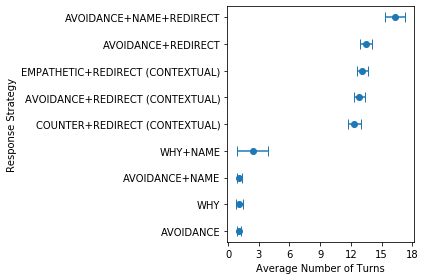

In [25]:
# All strategies plot

statistics = get_paired_statistic(derived_data, 'turns_til_end', *strategies)
y = np.array([statistics[f'mean{i}'] for i, _ in enumerate(strategies)])
err = np.array([statistics[f'se{i}'] for i, _ in enumerate(strategies)])
yticks = np.array(strategies)
sort_order = np.argsort(y)
y, err, yticks = y[sort_order], err[sort_order], yticks[sort_order]

title = 'Average Number of Turns Until the End (assuming no reoffense)'
plt.figure(figsize=(6, 4))
plt.errorbar(y, np.arange(len(y)), xerr=err, fmt='o', capsize=5)
plt.xticks(np.arange(0, 21, 3))
plt.yticks(np.arange(len(y)), yticks)
# plt.title(title)
plt.xlabel('Average Number of Turns')
plt.ylabel('Response Strategy')
plt.tight_layout()
plt.savefig(os.path.join('plot', title.replace(' ', '_').lower() + '.png'))

The plot above shows that on average, assuming the users did not reoffend, the strategies with a prompt has longer conversations after our response as compared to the strategies without a prompt. This indicates that when the no-prompt responses are able to stop the abuse, it did so by stopping the conversation immediately. On the other hand, the strategies with a prompt is able to redirect the user to engage longer with the bot.

### Part 1.3.1 Significance Analysis of Average Number of Turns Until the End of the Conversation (End)

In [26]:
def gen_table(derived_data, groups_of_strats, show_insig=False):
    headers = ['', 'Base', 'End', 'Alternative', 'End', 'Delta', 'p', 'cohens_d']
    rows = []
    for strats in groups_of_strats:
        statistics = get_paired_statistic(derived_data, 'turns_til_end', *strats)
        for i in range(1, len(strats)):
            if statistics[f'p_value_0_{i}'] < 0.05 or show_insig:
                rows.append([
                    len(rows) + 1,
                    strats[0].replace(' (CONTEXTUAL)', '*'), "{:.3f}".format(statistics[f'mean0']),
                    strats[i].replace(' (CONTEXTUAL)', '*'), "{:.3f}".format(statistics[f'mean{i}']),
                    "{:.3f}".format(statistics[f'mean_diff_0_{i}']), 
                    "{:.3g}".format(statistics[f'p_value_0_{i}']) \
                        if statistics[f'p_value_0_{i}'] > 1e-10 else "$<$ 1e-10",
                    "{:.3g}".format(statistics['cohens_d'])
                ])
    display(HTML(tabulate(rows, headers=headers, tablefmt='html')))
    rows = [[row[0]] + ["\\texttt{" + row[1] + "}"] + [row[2]] + ["\\texttt{" + row[3] + "}"] + row[4:]
            for row in rows]
    latex_code = tabulate(rows, headers=headers, tablefmt='latex_raw')
    return latex_code

In [27]:
latex_code = gen_table(derived_data, [('AVOIDANCE', 'AVOIDANCE+REDIRECT'), 
                           ('AVOIDANCE+NAME', 'AVOIDANCE+NAME+REDIRECT'),
                           ('AVOIDANCE+REDIRECT', 'AVOIDANCE+NAME+REDIRECT'), 
                           ('AVOIDANCE', 'AVOIDANCE+NAME'), 
                           ('WHY', 'WHY+NAME'),
                           ('AVOIDANCE+NAME', 'WHY+NAME'), 
                           ('AVOIDANCE', 'WHY'),
                           ('AVOIDANCE+REDIRECT', 'COUNTER+REDIRECT (CONTEXTUAL)'), 
                           ('AVOIDANCE+REDIRECT', 'EMPATHETIC+REDIRECT (CONTEXTUAL)')
                          ], True)
print(latex_code)

,Base,End,Alternative,End,Delta,p,cohens_d
1,AVOIDANCE,1.078,AVOIDANCE+REDIRECT,13.499,12.421,$<$ 1e-10,0.745
2,AVOIDANCE+NAME,1.111,AVOIDANCE+NAME+REDIRECT,16.313,15.202,7.03e-07,0.719
3,AVOIDANCE+REDIRECT,13.499,AVOIDANCE+NAME+REDIRECT,16.313,2.814,0.00881,0.144
4,AVOIDANCE,1.078,AVOIDANCE+NAME,1.111,0.033,0.928,0.0145
5,WHY,1.094,WHY+NAME,2.409,1.315,0.276,0.205
6,AVOIDANCE+NAME,1.111,WHY+NAME,2.409,1.298,0.366,0.187
7,AVOIDANCE,1.078,WHY,1.094,0.016,0.965,0.00606
8,AVOIDANCE+REDIRECT,13.499,COUNTER+REDIRECT*,12.337,-1.162,0.172,-0.0624
9,AVOIDANCE+REDIRECT,13.499,EMPATHETIC+REDIRECT*,13.126,-0.373,0.643,-0.0209


\begin{tabular}{rlrlrrlr}
\hline
    & Base                        &    End & Alternative                      &    End &   Delta & p         &   cohens_d \\
\hline
  1 & \texttt{AVOIDANCE}          &  1.078 & \texttt{AVOIDANCE+REDIRECT}      & 13.499 &  12.421 & $<$ 1e-10 &    0.745   \\
  2 & \texttt{AVOIDANCE+NAME}     &  1.111 & \texttt{AVOIDANCE+NAME+REDIRECT} & 16.313 &  15.202 & 7.03e-07  &    0.719   \\
  3 & \texttt{AVOIDANCE+REDIRECT} & 13.499 & \texttt{AVOIDANCE+NAME+REDIRECT} & 16.313 &   2.814 & 0.00881   &    0.144   \\
  4 & \texttt{AVOIDANCE}          &  1.078 & \texttt{AVOIDANCE+NAME}          &  1.111 &   0.033 & 0.928     &    0.0145  \\
  5 & \texttt{WHY}                &  1.094 & \texttt{WHY+NAME}                &  2.409 &   1.315 & 0.276     &    0.205   \\
  6 & \texttt{AVOIDANCE+NAME}     &  1.111 & \texttt{WHY+NAME}                &  2.409 &   1.298 & 0.366     &    0.187   \\
  7 & \texttt{AVOIDANCE}          &  1.078 & \texttt{WHY}                     &  1.09

The pair wise one way anova shows that there is a significant increase in the length of the rest of the conversation when adding a prompt to the response. Though there seems to be a significant increase when comparing AVOIDANCE+PROMPT and AVOIDANCE+NAME+PROMPT, as stated in our limitations section, this could be due to the fact that user who did not provide a name to our bot are less likely to be offensive in general, so this significance is somewhat weakened.

In [28]:
def gen_final_table(derived_data, groups_of_strats):
    headers = ['', 'Base', 'Alternative', '$\Delta$Re-offense', '$\Delta$End', '$\Delta$Next']
    rows = []
    for strats in groups_of_strats:
        statistics_reoffend = get_paired_statistic(derived_data, 'reoffend', *strats)
        statistics_end = get_paired_statistic(derived_data, 'turns_til_end', *strats)
        statistics_next = get_paired_statistic(derived_data, 'turns_til_next', *strats)
        for i in range(1, len(strats)):
            rows.append([
                len(rows) + 1,
                strats[0].replace(' (CONTEXTUAL)', ''),
                strats[i].replace(' (CONTEXTUAL)', ''),
                "\\textbf{{{:.3f}}}".format(statistics_reoffend[f'mean_diff_0_{i}']) \
                    if statistics_reoffend[f'p_value_0_{i}'] < 0.05\
                    else "{:.3f}".format(statistics_reoffend[f'mean_diff_0_{i}']),
                "\\textbf{{{:.3f}}}".format(statistics_end[f'mean_diff_0_{i}']) \
                    if statistics_end[f'p_value_0_{i}'] < 0.05\
                    else "{:.3f}".format(statistics_end[f'mean_diff_0_{i}']),
                "\\textbf{{{:.3f}}}".format(statistics_next[f'mean_diff_0_{i}']) \
                    if statistics_next[f'p_value_0_{i}'] < 0.05\
                    else "{:.3f}".format(statistics_next[f'mean_diff_0_{i}']),
            ])
    display(HTML(tabulate(rows, headers=headers, tablefmt='html')))
    rows = [[row[0]] + ["\\texttt{" + row[1] + "}"] + ["\\texttt{" + row[2] + "}"] + row[3:]
            for row in rows]
    latex_code = tabulate(rows, headers=headers, tablefmt='latex_raw')
    return latex_code

In [29]:
latex_code = gen_final_table(derived_data, [('AVOIDANCE', 'AVOIDANCE+REDIRECT'), 
                           ('AVOIDANCE+NAME', 'AVOIDANCE+NAME+REDIRECT'),
                           ('AVOIDANCE+REDIRECT', 'AVOIDANCE+NAME+REDIRECT'), 
                           ('AVOIDANCE', 'AVOIDANCE+NAME'), 
                           ('WHY', 'WHY+NAME'),
                           ('AVOIDANCE+NAME', 'WHY+NAME'), 
                           ('AVOIDANCE', 'WHY'),
                           ('AVOIDANCE+REDIRECT', 'COUNTER+REDIRECT (CONTEXTUAL)'), 
                           ('AVOIDANCE+REDIRECT', 'EMPATHETIC+REDIRECT (CONTEXTUAL)')
                          ])
print(latex_code)

,Base,Alternative,$\Delta$Re-offense,$\Delta$End,$\Delta$Next
1,AVOIDANCE,AVOIDANCE+REDIRECT,\textbf{-0.452},\textbf{12.421},\textbf{6.311}
2,AVOIDANCE+NAME,AVOIDANCE+NAME+REDIRECT,\textbf{-0.532},\textbf{15.202},\textbf{7.584}
3,AVOIDANCE+REDIRECT,AVOIDANCE+NAME+REDIRECT,\textbf{-0.060},\textbf{2.814},1.281
4,AVOIDANCE,AVOIDANCE+NAME,0.020,0.033,0.007
5,WHY,WHY+NAME,-0.004,1.315,0.288
6,AVOIDANCE+NAME,WHY+NAME,0.010,1.298,0.316
7,AVOIDANCE,WHY,\textbf{0.033},0.016,0.035
8,AVOIDANCE+REDIRECT,COUNTER+REDIRECT,0.005,-1.162,-0.486
9,AVOIDANCE+REDIRECT,EMPATHETIC+REDIRECT,\textbf{-0.035},-0.373,-0.603


\begin{tabular}{rlllll}
\hline
    & Base                        & Alternative                      & $\Delta$Re-offense   & $\Delta$End     & $\Delta$Next   \\
\hline
  1 & \texttt{AVOIDANCE}          & \texttt{AVOIDANCE+REDIRECT}      & \textbf{-0.452}      & \textbf{12.421} & \textbf{6.311} \\
  2 & \texttt{AVOIDANCE+NAME}     & \texttt{AVOIDANCE+NAME+REDIRECT} & \textbf{-0.532}      & \textbf{15.202} & \textbf{7.584} \\
  3 & \texttt{AVOIDANCE+REDIRECT} & \texttt{AVOIDANCE+NAME+REDIRECT} & \textbf{-0.060}      & \textbf{2.814}  & 1.281          \\
  4 & \texttt{AVOIDANCE}          & \texttt{AVOIDANCE+NAME}          & 0.020                & 0.033           & 0.007          \\
  5 & \texttt{WHY}                & \texttt{WHY+NAME}                & -0.004               & 1.315           & 0.288          \\
  6 & \texttt{AVOIDANCE+NAME}     & \texttt{WHY+NAME}                & 0.010                & 1.298           & 0.316          \\
  7 & \texttt{AVOIDANCE}          & \texttt{WHY}    

## Part 2. Offense Type Analysis

In this section we briefly summarize the types of offenses we are getting as well as their frequencies. After we manually annotated the top 500 offensive utterances, we also annotated the type of offense that they belong to as well into 5 broad categories. However, we will not include these analysis in our paper due to page limit, but interested readers may draw interesting conclusions from this section


In [30]:
# Finding all the different offense types that exist in our dataset
offense_types = list(set(offensive_turn['offense_type'] for metadata in data for offensive_turn in metadata['offensive_turns']))

# Summarizing the findings
print(f"The offense types that exist in our dataset are:\n\n  {offense_types}")

The offense types that exist in our dataset are:

  ['curse', 'inappropriate topic', 'criticism', 'sexual', 'bodily harm']


### i. Number of Utterances by Offense Type

We first want to analyze how common each offense type is in our dataset. To do so, we count how many utterances are attributed to each offense type.

In [31]:
# Counting the number of occurence of each offense type
utterance_offense_types_list = [offensive_turn['offense_type'] for metadata in data for offensive_turn in metadata['offensive_turns']]
utterance_offense_types_counter = Counter(utterance_offense_types_list)

# Summarizing the findings
print(f"There are total of {len(utterance_offense_types_list)} offensive utterances in our dataset.")
print("Number of offensive utterances for each offense type:")
utterance_offense_types_counter

There are total of 49511 offensive utterances in our dataset.
Number of offensive utterances for each offense type:


Counter({'sexual': 24808,
         'curse': 7685,
         'inappropriate topic': 11455,
         'criticism': 5100,
         'bodily harm': 463})

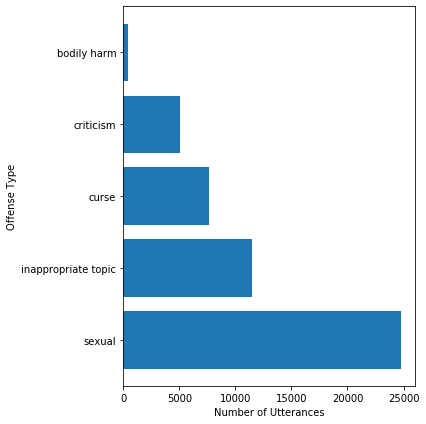

In [32]:
# Preparing the data for plotting
labels, values = zip(*utterance_offense_types_counter.most_common())
indices = list(range(0, len(labels)))
BAR_WIDTH = 0.8

# Plotting the data
plt.figure(figsize=(6, 6))
plt.barh(indices, values, BAR_WIDTH)
plt.yticks(indices, labels) # TODO use a make title function
# plt.title('Number of Utterances by Offense Type')
plt.ylabel('Offense Type')
plt.xlabel('Number of Utterances')
plt.tight_layout()
plt.savefig('number_of_utterances_by_offense_type.png')

From the figure above it can be seen that more than half of the offensive turns are attributed to sexual offenses. However, it is also possible that the reason we captured this many sexual offenses is because we have selected many sexually offensive phrases as part of our 500-phrases.

### ii. Co-occurence of Offense Types

We are also interested in whether different types co-occur.

In [33]:
# Calculate the co-occurence matrix 
def calculate_offense_type_cooccurence_matrix(data):
    inds = dict((t, ind) for ind, t in enumerate(offense_types))
    matrix = np.zeros((len(offense_types), len(offense_types)))

    offensive_user_convo_types = [Counter(offensive_turn['offense_type'] for offensive_turn in metadata['offensive_turns']) for metadata in data]
    for c in offensive_user_convo_types:
        # First count diagonal entries
        for t, count in c.items():
            if count > 1:
                matrix[inds[t], inds[t]] += 1
        # Then count everything else
        for (t1, _), (t2, _) in combinations(c.items(), 2):
            if t1 != t2:
                matrix[inds[t1], inds[t2]] += 1
                matrix[inds[t2], inds[t1]] += 1

    return matrix

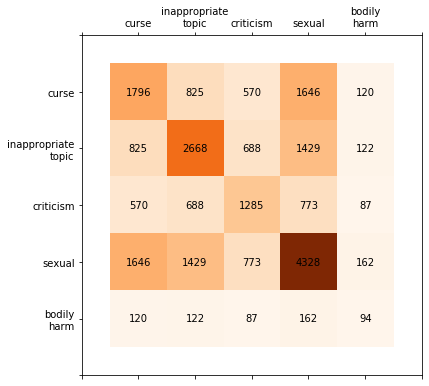

In [34]:
# Prepare the data
matrix = calculate_offense_type_cooccurence_matrix(data)

# Plot the data
fig = plt.figure(figsize=(6, 6))
ax = fig.subplots()
ax.matshow(matrix, cmap=plt.cm.Oranges)
for (x, y), value in np.ndenumerate(matrix):
    ax.text(x, y, f"{int(value)}", va='center', ha='center')
x_labels = [''] + [label for label in offense_types] + [''] # TODO Fix the label
x_labels = ['\n'.join(label.split(' ')) for label in x_labels]# TODO Fix the label
ax.set_xticks(range(-1, 6))
ax.set_xticklabels(x_labels)
ax.set_yticks(range(-1, 6))
ax.set_yticklabels(x_labels)
# plt.xticks(range(0, 5), x_labels) # TODO Fix the label
# plt.yticks(range(0, 5), offense_types)
fig.tight_layout()
# plt.title('Offense Type Co-occurrence Matrix')
fig.savefig('type_cooccurrence.png')

Note that all entries of the co-occurance matrix above are for conversations with more than 1 type of offenses (and diagonal entries counts conversations with the same repeated offenses) 

The plot above shows that users who make sexually offensive remarks are also much more likely to bring up inappropriate topics, meaning that these offenders made a broader attempt to offend our bot instead of just sexually offending. However, this could also be an effect of classification, since most curse words are sexual in nature and many inappropriate topics are also sexual in nature

### iii. Relationship Between Offense Type and the Probability of Re-offense

The question we are interested in is whether the type of initial offense affect the probability of whether or not user would reoffend. We want to be able to see whether we can predict how "determined" a user is in offending us by their initial offense type. 

We are also interested to know whether the type of offense can also indicate user's "intention" by measuring the probability that user will only use the same type of offense for the rest of the conversation given they have offended.

Note that in this analysis, it is possible that we did not respond to the initial offense due to a limitation with our bot which will be described in detail in the paper.

In [35]:
# Function calculating the estimated probability and the confidence interval
def calculate_estimated_probability(values):
    p = np.mean(values)
    ci = 2 * np.sqrt(p * (1 - p) / len(values))
    return p, ci

# Initialize the dictionaries holding the expected probability of re-offending and the confidence interval for each offense type
y_reoffense_one_hot_any = {}
y_reoffense_one_hot_sole = {}

# Iterate through all the offense types and calculate the probability of re-offending
for offense_type in offense_types:
    # Filter the data to only consider the conversations where the initial offense is the same as the offense_type
    filtered_metadata = [metadata for metadata in data if offense_type == metadata['offensive_turns'][0]['offense_type']]
    # Create a list containing whether or not there is a repeat offense for each of the filtered datapoints
    reoffense_one_hot_any = [len(metadata['offensive_turns']) > 1 for metadata in filtered_metadata]
    reoffense_one_hot_sole = [all(turn['offense_type'] == offense_type 
                                  for turn in metadata['offensive_turns'][1:])
                              for metadata in filtered_metadata if len(metadata['offensive_turns']) > 1]
    # Calculate the expected probability of re-offending and the confidence interval
    y_reoffense_one_hot_any[offense_type] = calculate_estimated_probability(reoffense_one_hot_any)
    y_reoffense_one_hot_sole[offense_type] = calculate_estimated_probability(reoffense_one_hot_sole)
    
# Printing an example y # TODO better printing
print("Re-offense probabilities and the standard error associated with them for each offense type:")
headers = ['Type', 
           'P(reoffend|type)', 'CI', 
#            'P(reoffend same)', 'CI', 'P(reoffend diff)', 'CI', 
           'P(sole|reoffend, type)', 'CI']
ordered_types = sorted(y_reoffense_one_hot_any.keys(), 
                       key=lambda t: y_reoffense_one_hot_any[t][0], reverse=True)
rows = []
for offense_type in ordered_types:
    rows.append([
        offense_type,
        y_reoffense_one_hot_any[offense_type][0],
        y_reoffense_one_hot_any[offense_type][1],
        y_reoffense_one_hot_sole[offense_type][0],
        y_reoffense_one_hot_sole[offense_type][1]
    ])
display(HTML(tabulate(rows, headers=headers, tablefmt='html')))
# print(tabulate(rows, headers=headers, tablefmt='latex'))

Re-offense probabilities and the standard error associated with them for each offense type:


Type,P(reoffend|type),CI,"P(sole|reoffend, type)",CI
bodily harm,0.815789,0.0726146,0.215054,0.0852083
sexual,0.734068,0.01208,0.616344,0.0155177
inappropriate topic,0.674086,0.0152594,0.603774,0.0193946
curse,0.663757,0.0202503,0.407612,0.0258537
criticism,0.601613,0.0227031,0.596068,0.0293371


From the table above, we can see that user is much more likely to offend if the initial offense type is bodily harm, but user usually will use a different tactict when reoffending. On the contrary, users who initially offend using sexually explicit language are not only more likely to reoffend (at 0.73 reoffend rate probability) but are also more likely to reoffend using solely sexually explicit languages (at 0.61 sole offense probability). This shows that **users who offend our bot sexually are not only more motivated, but also more intended in offending our bot sexually.** 